## Quantum Secret Sharing
### Keanu Spies
In this notebook we show our work in defining a quantum secret sharing protocol on an arbitrary number of qubits. We follow the work shown by Hillery et al. in their paper "Quantum Secret Sharing"

In [1]:
from pyquil import get_qc
from pyquil.quil import Program, address_qubits
from pyquil.api import QVMConnection
from pyquil.quilatom import QubitPlaceholder
from pyquil.gates import *
from pyquil.noise import (estimate_bitstring_probs, correct_bitstring_probs,
                          bitstring_probs_to_z_moments, estimate_assignment_probs)
import matplotlib.pyplot as plt
from plotquil import *
import numpy as np
import random
from shor_code import shor

In [2]:
qvm = QVMConnection()

# Sharing a single qubit secret

### Part 1.1 GHZ state
First we will show secret sharing of a single qubit between three parties. To do so we will first create a maximally entangle 3 qubit (GHZ) state. Consider these qubits as Alice: 0, Bob: 1, Charlie: 2

In [3]:
ghz = {'alice': 0,
       'bob' : 1,
       'charlie' : 2
      }

In [4]:
def entangle(pq, ghz, name='alice'):
    # create map of qubits
    if name != 'charlie': pq += H(ghz[name])
    if name == 'alice': pq += CNOT(ghz['alice'], ghz['bob'])
    if name != 'charlie': pq += CNOT(ghz[name], ghz['charlie'])
    return pq

def unentangle(pq, ghz, name='alice'):
    # create map of qubits
    if name != 'charlie': pq += CNOT(ghz['charlie'], ghz[name])
    if name == 'alice': pq += CNOT(ghz['bob'], ghz['alice'])
    if name != 'charlie': pq += H(ghz[name])
    return pq

In [5]:
def measurefor(person, direction, currpq, ro, ghz):
    currpq = entangle(currpq, ghz, name=person)
    currpq += direction(ghz[person])
    currpq = unentangle(currpq, ghz, name=person)
    currpq += MEASURE(ghz[person], ro)
    return currpq

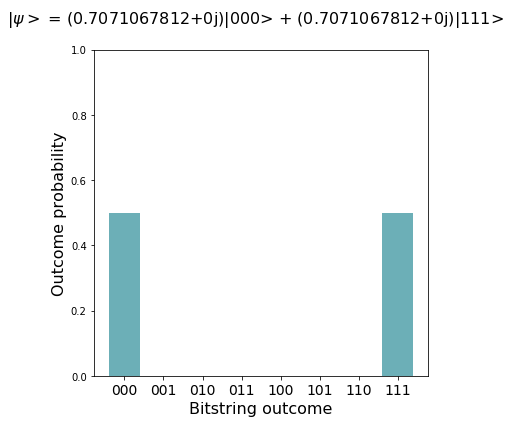

In [6]:
pq = Program()
pq = entangle(pq, ghz)
wf = qvm.wavefunction(pq)
plot_wf(wf)

Now since we have a maximally entangled state between the three parties we can begin the secret sharing. 

### Part 1.2 Secret Protocol

Quantum secret sharing works under the above GHZ state. Assume that Alice is the party sharing the secret to Bob and Charlie. In order for Bob and Charlie to uncover exactly which qubit alice sent with certainty they will both need to do the reading and communicate with Alice under which Basis to do the reading. This works becase we can expand the GHZ state into the following: 

$$\begin{align}|\psi_i \rangle  &= \frac{1}{2\sqrt{2}} \bigg[(|+ x\rangle_a |+x \rangle_b + | − x\rangle_a |−x\rangle_b)(|0\rangle_c + |1\rangle_c)\\ &+(| + x\rangle_a| − x\rangle_b + | − x\rangle_a| + x\rangle_b)(|0\rangle_c − |1\rangle_c)\bigg] .\end{align} $$

Meaning that Charlie is able to tell whether Alice and Bob made their readings along the same basis ($\pm$x) or not but has no way of knowing what their readings were precisely (Hillery et all 1998). This is however reqiures that Charlie do his reading in the same direction that Alice and Bob did their readings (i.e. x direction) in order to determine if Alice and Bob's readings were correlated or anti-correlated. Similarly Bob needs Charlie in order to determine if his reading is the same or different to Alices. 

Thus the three parties should all perform their reading in the same direction which should be announced beforehand. This should happen as follows (according to Hillery et al.): Charlie and Bob each measure in the same direction and send their direction to Alice, who measures in a specific direction and sends all three directions to Bob and Charlie. 

Below I will present the table of reading results from this system that was presented in Hillerey et al. Where columns represent Alices readings row's represent Bobs and values inside the cells are Charlies readings.

|-                | \|+x$\rangle$              | \|-x$\rangle$               | \|+y$\rangle$               | \|-y$\rangle$               |
|----------------|------------------------------|------------------------------|------------------------------|------------------------------|
| **\|+x$\rangle$** | \|0$\rangle$ + \|1$\rangle$  | \|0$\rangle$ - \|1$\rangle$  | \|0$\rangle$ - i\|1$\rangle$ | \|0$\rangle$ + i\|1$\rangle$ |
| **\|-x$\rangle$** | \|0$\rangle$ - \|1$\rangle$  | \|0$\rangle$ + \|1$\rangle$  | \|0$\rangle$ + i\|1$\rangle$ | \|0$\rangle$ - i\|1$\rangle$ |
| **\|+y$\rangle$** | \|0$\rangle$ - i\|1$\rangle$ | \|0$\rangle$ + i\|1$\rangle$ | \|0$\rangle$ - \|1$\rangle$  | \|0$\rangle$ + \|1$\rangle$  |
| **\|-y$\rangle$** | \|0$\rangle$ + i\|1$\rangle$ | \|0$\rangle$ - i\|1$\rangle$ | \|0$\rangle$ + \|1$\rangle$  | \|0$\rangle$ - \|1$\rangle$  |

 ### Part 1.2.1 Protecting against evesdropping
 
 First I will concretely show how this method protects against evesdropping. Assume that Bob has malicious intent and steals Charlies qubit and attempts to uncover Alices infomation. 
 
 Consider that Alice chose to measure in the y direction.

Now Bob will choose to measure either in a correlated or uncorrelated fashion (i.e. read his and Charlies qubit in either the same of different directions).

**Part 1**: Reading in the incorrect manner <br>
Since Alice measured in the Y direction, Bob and Charlie need to measure in an anticorrelated way in order to determine what Alice's qubit state is. Consider when Bob measures in a correlated (the incorrect) fashion. 

In [7]:
pq = Program()
ro = pq.declare('ro', 'BIT', 3)
pq = measurefor('alice', Y, pq, ro[0], ghz)
pq = measurefor('bob', X, pq, ro[1], ghz)
pq = measurefor('charlie', X, pq, ro[2], ghz)
result = qvm.run(pq)
print(result)

[[1, 1, 1]]


We see that Alice read $|-y\rangle$, Bob read $|-x\rangle$ from his own qubit and $|-x\rangle$ from Charlie's qubit. But we can see that Bob lost the information from Charlie's qubit since he should have read $|-y\rangle$ from Charlie's qubit but he measured in the wrong fashion. With this in-correct measurement Bob would assume that alice would have read $|+x\rangle$ and would produce the wrong key with Alice. 

**Part 2**: Reading in the correct manner<br>
Next Consider when he measures in the correct (anti-correlated way). 

In [8]:
pq = Program()
ro = pq.declare('ro', 'BIT', 3)
pq = measurefor('alice', Y, pq, ro[0], ghz)
pq = measurefor('bob', X, pq, ro[1], ghz)
pq = measurefor('charlie', Y, pq, ro[2], ghz)
result = qvm.run(pq)
print(result)

[[0, 0, 1]]


In [9]:
print(pq)

DECLARE ro BIT[3]
H 0
CNOT 0 1
CNOT 0 2
Y 0
CNOT 2 0
CNOT 1 0
H 0
MEASURE 0 ro[0]
H 1
CNOT 1 2
X 1
CNOT 2 1
H 1
MEASURE 1 ro[1]
Y 2
MEASURE 2 ro[2]



We see that Alice read  |+y⟩ , Bob read  |+𝑥⟩  from his own qubit and  |-y⟩  from Charlie's qubit. This is the expected result, meaning that Bob would correctly be able to recreate alices qubit.

## Creating a secret key

Next we need to show how to create a secret key between the parties to allow for a encrypted exchange. Assume we want to have an 8 bit key. 

To do this we need to use 8 GHZ states to share the secret since each bit will need to be decoded with the collective work of Bob and Charlie in order to find Alices bit. 

In [10]:
# each person will define their measurement
# this function also takes in the ghz state as well as what vm to use 
# (this is mainly for error codes later in the project)
def one_bit_measurement(alice_dir, bob_dir, charlie_dir, ghz, vm):
    pq = Program()
    ro = pq.declare('ro', 'BIT', 3)
    pq = measurefor('alice', alice_dir, pq, ro[0], ghz)
    pq = measurefor('bob', bob_dir, pq, ro[1], ghz)
    pq = measurefor('charlie', charlie_dir, pq, ro[2], ghz)
    result = vm.run(address_qubits(pq))
    return result

In [11]:
def create_secret_key(num_bits, ghz, vm=qvm):
    alice_out = []
    bob_out = []
    charlie_out = []
    for i in range(num_bits):
        alice_offset = 0
        bob_offset = 0
        charlie_offset = 0
        # bob and charlie choose their directions to measure
        bob_dir = random.choice([X, Y])
        if bob_dir == Y: bob_offset = 2
        charlie_dir = random.choice([X, Y])
        if charlie_dir == Y: charlie_offset = 2
        # they send their directions to alice
        # she chooses X if bob and charlie has the same dir
        # or Y if they had opposite
        if bob_dir == charlie_dir: 
            alice_dir = X
        else: 
            alice_dir = Y
            alice_offset = 2
        # measure for all parties. 
        ro = one_bit_measurement(alice_dir, bob_dir, charlie_dir, ghz, vm)
        alice_out.append(ro[0][0] + alice_offset)
        bob_out.append(ro[0][1] + bob_offset)
        charlie_out.append(ro[0][2] + charlie_offset)
    return alice_out, bob_out, charlie_out

In order to reconstruct the key, Bob and Charlie need to work together to know what Alice would have read, once this key has been established they can share their secret

In [12]:
reconstruction_map = {
        # X X
        (0, 0): 0, (0, 1): 1, (1, 0): 1, (1, 1): 0,
        # Y Y 
        (2, 2): 1, (2, 3): 0, (3, 2): 0, (3, 3): 1, 
        # X Y
        (0, 2): 3, (0, 3): 2, (1, 2): 2, (1, 3): 3,
        # Y X
        (2, 0): 2, (2, 1): 3,(3, 0): 3,(3, 1): 2
    }

In [13]:
def reconstruct(alice_out, bob_out, charlie_out):
    reconstructed = []
    for i in range(len(bob_out)):
        reconstructed.append(reconstruction_map[(bob_out[i], charlie_out[i])])
    return reconstructed

In [14]:
alice_out, bob_out, charlie_out = create_secret_key(8, ghz)
reconstructed = reconstruct(alice_out, bob_out, charlie_out)
print(alice_out)
print(reconstructed)

[2, 2, 0, 0, 3, 3, 1, 1]
[2, 2, 0, 0, 3, 3, 1, 1]


In [15]:
## share a secret many times to determine if the system is consistent.
correct = 0
for i in range(100):
    alice_out, bob_out, charlie_out = create_secret_key(8, ghz)
    reconstructed = reconstruct(alice_out, bob_out, charlie_out)
    if alice_out == reconstructed:
        correct += 1
print('Percentage correct key between parties = ', correct, '%')

Percentage correct key between parties =  100 %


As we can see, the key has been reconstructed correctly between the parties.

In [16]:
# TODO: explore the XOR feature more etc.

## Part 2. Sharing with Noise

### Part 2.1 Readot Noise
First we will consider when the GHZ state has noisy readout decay associated with it and a method to combat the decay. From the pyquil docuumentation we see that we can model the decay/errors in a GHZ state as follows:

In [17]:
# for noise simulation 
header0 = Program().define_noisy_readout(0, .85, .95)
header1 = Program().define_noisy_readout(1, .8, .9)
header2 = Program().define_noisy_readout(2, .9, .85)

# for noise correction  
ap0 = estimate_assignment_probs(0, 100000, qvm, header0)
ap1 = estimate_assignment_probs(1, 100000, qvm, header1)
ap2 = estimate_assignment_probs(2, 100000, qvm, header2)

# creating a GHZ state and using noise in the measurement.
ghz_prog = Program()
ro = ghz_prog.declare('ro', 'BIT', 3)
ghz_prog += Program(H(0), CNOT(0, 1), CNOT(1, 2),
                   MEASURE(0, 0), MEASURE(1, 1), MEASURE(2, 2))

header = header0 + header1 + header2
noisy_ghz = header + ghz_prog

/usr/local/lib/python3.6/site-packages/pyquil/gates.py:490: UserWarning: Indexing measurement addresses by integers is deprecated. Replacing this with the MemoryReference ro[i] instead.
  + "Replacing this with the MemoryReference ro[i] instead.")
/usr/local/lib/python3.6/site-packages/pyquil/quil.py:902: UserWarning: Please DECLARE all memory. I'm adding a declaration for the `ro` register, but I won't do this for you in the future.
  warnings.warn("Please DECLARE all memory. I'm adding a declaration for the `ro` register, "


Consider first the ideal non-noise case. Here the GHZ state does not decay. Here the results are the the estimated probabilities of each of values of $\alpha$ and $\beta$ where the state is $$\alpha |000\rangle + \beta |111\rangle$$

In [18]:
results = qvm.run(ghz_prog, [0, 1, 2], trials=10000)
probs = estimate_bitstring_probs(results)
print('alpha^2: ', probs[0, 0, 0], 'beta^2: ', probs[1, 1, 1])

alpha^2:  0.5008 beta^2:  0.4992


Consider next the noisy case where the state might decay and we no longer have a stable GHZ pair. Note that $\alpha$ and $\beta$ have decayed and the state is no longer in its maximally entangled state.

In [19]:
noisy_results = qvm.run(noisy_ghz, [0, 1, 2], trials=10000)
noisy_probs = estimate_bitstring_probs(noisy_results)
print('alpha^2: ', noisy_probs[0, 0, 0], 'beta^2: ', noisy_probs[1, 1, 1])

alpha^2:  0.3116 beta^2:  0.3648


PyQuil provides an API to correct these errors, however, allowing for us to reach a state more closely related to the ideal GHZ.

In [20]:
corrected_probs = correct_bitstring_probs(noisy_probs, [ap0, ap1, ap2])
print('alpha^2: ', corrected_probs[0, 0, 0], 'beta^2: ', corrected_probs[1, 1, 1])

alpha^2:  0.5076359377307773 beta^2:  0.5048859936518564


### Part 2.2 Bit and Phase flips
Next we will consider noise that might occur over time as Alice sends Bob and Charlie their qubits after entanglement. Since the qubits are travelling a distance there is the possibility that they will experience either a bit flip or a phase flip.

In [21]:
qc = get_qc('3q-noisy-qvm')

In [22]:
correct = 0
for i in range(100):
    alice_out, bob_out, charlie_out = create_secret_key(8, ghz, qc)
    reconstructed = reconstruct(alice_out, bob_out, charlie_out)
    if alice_out == reconstructed:
        correct += 1
print('Percentage correct key between parties = ', correct, '%')

Percentage correct key between parties =  27 %


#### Part 2.2.1 Bit Flip
Consider the following code deried from the pyquil documentation for a bit flip

In [23]:
def damping_channel(damp_prob=.1):
    damping_op = np.sqrt(damp_prob) * np.array([[0, 1], [0, 0]])
    residual_kraus = np.diag([1, np.sqrt(1-damp_prob)])
    return [residual_kraus, damping_op]

def append_kraus_to_gate(kraus_ops, g):
    return [kj.dot(g) for kj in kraus_ops]

def append_damping_to_gate(gate, damp_prob=.1):
    return append_kraus_to_gate(damping_channel(damp_prob), gate)

In [24]:
def simulate_noise(ghz, use_shor=False, kraus_operator=None):
    # single step damping probability
    damping_per_I = 0.02
    # number of program executions
    trials = 10000
    dampened_encoding = []
    results_damping = []
    lengths = np.arange(0, 301, 10, dtype=int)
    for jj, num_I in enumerate(lengths):
        pq = Program()
        ro = pq.declare('ro', 'BIT', 3)
        
        # 1. Alice creates the ghz state
        pq = entangle(pq, ghz, name='alice')
        
        # 2. Some amount of time passes as the qubits are sent to
        #    Bob and Charlie 
        pq.inst([I(ghz['alice']) for _ in range(num_I)])
        pq.inst([I(ghz['bob']) for _ in range(num_I)])
        pq.inst([I(ghz['charlie']) for _ in range(num_I)])
        
        # 3. Bob and charlie chose their measurement direction
        alice_offset = bob_offset = charlie_offset = 0
        bob_dir = random.choice([X, Y])
        if bob_dir == Y: bob_offset = 2
        charlie_dir = random.choice([X, Y])
        if charlie_dir == Y: charlie_offset = 2
            
        # 4. They inform alice and she decides a direction based on
        #    their parity.
        if bob_dir == charlie_dir: alice_dir = X
        else: 
            alice_dir = Y
            alice_offset = 2
            
        # 5. They all perform their measurements. 
        pq += alice_dir(ghz['alice'])
        pq = unentangle(pq, ghz, name='alice')
        pq += MEASURE(ghz['alice'], ro[0])
        pq = measurefor('bob', bob_dir, pq, ro[1], ghz)
        pq = measurefor('charlie', charlie_dir, pq, ro[2], ghz)

        # overload identity I on qc 0
        pq.define_noisy_gate("I", [ghz['alice']], append_damping_to_gate(np.eye(2), damping_per_I))
        pq.define_noisy_gate("I", [ghz['bob']], append_damping_to_gate(np.eye(2), damping_per_I))
        pq.define_noisy_gate("I", [ghz['charlie']], append_damping_to_gate(np.eye(2), damping_per_I))
        pq.wrap_in_numshots_loop(trials)
        qvm.random_seed = int(num_I)
        res = qvm.run(address_qubits(pq), trials=trials)
        
        num_correct = 0
        for a,b,c in res:
            if reconstruction_map[(b + bob_offset, c + charlie_offset)] == a + alice_offset:
                num_correct += 1
        
        results_damping.append([num_correct/trials])
        
    return results_damping

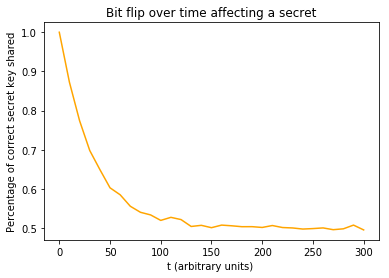

In [25]:
ghz = {'alice': QubitPlaceholder(),
       'bob' : QubitPlaceholder(),
       'charlie' : QubitPlaceholder()}
noisy_out = simulate_noise(ghz)
plt.plot(range(0,301, 10), noisy_out, color='orange')
plt.xlabel('t (arbitrary units) ')
plt.ylabel('Percentage of correct secret key shared')
plt.title('Bit flip over time affecting a secret')
plt.savefig('./plots/bit_flip.png')

### Part 2.2.2 Dephasing channel

Here I show the effects of a depolarizing channel on the system. 

In [26]:
def depolarizing_channel(prob: float): 
    noisy_I = np.sqrt(1-prob) * np.asarray([[1, 0], [0, 1]])
    noisy_X = np.sqrt(prob/3) * np.asarray([[0, 1], [1, 0]])
    noisy_Y = np.sqrt(prob/3) * np.asarray([[0, -1j], [1j, 0]])
    noisy_Z = np.sqrt(prob/3) * np.asarray([[1, 0], [0, -1]])
    return [noisy_I , noisy_X , noisy_Y , noisy_Z]

In [27]:
def simulate_noise_dephase(ghz, use_shor=False, kraus_operator=None):
    # single step damping probability
    damping_per_I = 0.02
    # number of program executions
    trials = 10000
    dampened_encoding = []
    results_damping = []
    lengths = np.arange(0, 301, 10, dtype=int)
    for jj, num_I in enumerate(lengths):
        pq = Program()
        ro = pq.declare('ro', 'BIT', 3)
        
        # 1. Alice creates the ghz state
        pq = entangle(pq, ghz, name='alice')
        
        # 2. Some amount of time passes as the qubits are sent to
        #    Bob and Charlie 
        pq.inst([I(ghz['alice']) for _ in range(num_I)])
        pq.inst([I(ghz['bob']) for _ in range(num_I)])
        pq.inst([I(ghz['charlie']) for _ in range(num_I)])
        
        # 3. Bob and charlie chose their measurement direction
        alice_offset = bob_offset = charlie_offset = 0
        bob_dir = random.choice([X, Y])
        if bob_dir == Y: bob_offset = 2
        charlie_dir = random.choice([X, Y])
        if charlie_dir == Y: charlie_offset = 2
            
        # 4. They inform alice and she decides a direction based on
        #    their parity.
        if bob_dir == charlie_dir: alice_dir = X
        else: 
            alice_dir = Y
            alice_offset = 2
            
        # 5. They all perform their measurements. 
        pq += alice_dir(ghz['alice'])
        pq = unentangle(pq, ghz, name='alice')
        pq += MEASURE(ghz['alice'], ro[0])
        pq = measurefor('bob', bob_dir, pq, ro[1], ghz)
        pq = measurefor('charlie', charlie_dir, pq, ro[2], ghz)

        # overload identity I, X, Y, and Z
        pq.define_noisy_gate("I", [ghz['bob']], append_damping_to_gate(np.eye(2), damping_per_I))
        pq.define_noisy_gate("X", [ghz['bob']], append_damping_to_gate(np.asarray([[0, 1], [1, 0]]), 
                                                                       1/np.sqrt(3)))
        pq.define_noisy_gate("Y", [ghz['bob']], append_damping_to_gate(np.asarray([[0, -1j], [-1j, 0]]), 
                                                                       1/np.sqrt(3)))
        pq.define_noisy_gate("Z", [ghz['bob']], append_damping_to_gate(np.asarray([[1, 0], [0, -1]]), 
                                                                       1/np.sqrt(3)))
        pq.wrap_in_numshots_loop(trials)
        qvm.random_seed = int(num_I)
        res = qvm.run(address_qubits(pq), trials=trials)
        
        num_correct = 0
        for a,b,c in res:
            if reconstruction_map[(b + bob_offset, c + charlie_offset)] == a + alice_offset:
                num_correct += 1
        
        results_damping.append([num_correct/trials])
        
    return results_damping

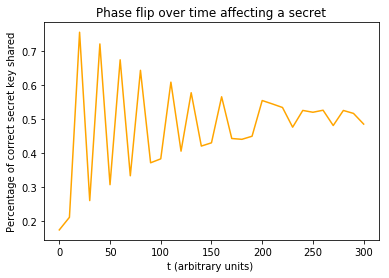

In [28]:
ghz = {'alice': QubitPlaceholder(),
       'bob' : QubitPlaceholder(),
       'charlie' : QubitPlaceholder()}
noisy_ou2t = simulate_noise_dephase(ghz)
plt.plot(range(0,301, 10), noisy_ou2t, color='orange')
plt.xlabel('t (arbitrary units) ')
plt.ylabel('Percentage of correct secret key shared')
plt.title('Phase flip over time affecting a secret')
plt.savefig('./plots/phase_flip.png')

We can use a shor code to potentially ablate the noise in the system.